# Assignment 2: Language Modelling in Hangman

Student Name: Kexin Chen

Student ID: 1240143

## General info

<b>Due date</b>: Wednesday, 3 April 2024 1pm

<b>Submission method</b>: Canvas submission

<b>Submission materials</b>: completed copy of this iPython notebook

<b>Late submissions</b>: -20% per day (both week and weekend days counted)

<b>Marks</b>: 8% of mark for class (with 7% on correctness + 1% on quality and efficiency of your code)

<b>Materials</b>: See "Using Jupyter Notebook and Python page" on Canvas (under Modules>Resources) for information on the basic setup required for this class, including an iPython notebook viewer and the python packages NLTK, Numpy, Scipy, Matplotlib, Scikit-Learn, Gensim, Keras and Pytorch. We recommend installing all the data for NLTK, since you will need various parts of it to complete this assignment. You can also use any Python built-in packages, but do not use any other 3rd party packages (the packages listed above are all fine to use); if your iPython notebook doesn't run on the marker's machine, you will lose marks. <b> You should use Python 3.8</b>; libraries/packages should be in their latest version that is compatible with python3.8.  

To familiarize yourself with NLTK, here is a free online book:  Steven Bird, Ewan Klein, and Edward Loper (2009). <a href=https://www.nltk.org/book/>Natural Language Processing with Python</a>. O'Reilly Media Inc. You may also consult the <a href=https://www.nltk.org/api/nltk.html>NLTK API</a>.

<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time, and you must follow all instructions provided below, including specific implementation requirements and instructions for what needs to be printed (please avoid printing output we don't ask for). You should edit the sections below where requested, but leave the rest of the code as is. You should leave the output from running your code in the iPython notebook you submit, to assist with marking. The amount each question is worth is explicitly given. 

You will be marked not only on the correctness of your methods, but also the quality and efficency of your code: in particular, you should be careful to use Python built-in functions and operators when appropriate and pick descriptive variable names that adhere to <a href="https://www.python.org/dev/peps/pep-0008/">Python style requirements</a>. If you think it might be unclear what you are doing, you should comment your code to help the marker make sense of it.

<b>Updates</b>: Any major changes to the assignment will be announced via Canvas. Minor changes and clarifications will be announced on the discussion board; we recommend you check it regularly.

<b>Academic misconduct</b>: For most people, collaboration will form a natural part of the undertaking of this homework, and we encourge you to discuss it in general terms with other students. However, this ultimately is still an individual task, and so reuse of code or other instances of clear influence will be considered cheating. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place. In regards to the use of artificial intelligence tools in the context of academic integrity, please see the university's statement <a href="https://academicintegrity.unimelb.edu.au/plagiarism-and-collusion/artificial-intelligence-tools-and-technologies">here</a>.

# Overview

In this homework, you'll be creating an 'artificial intelligence' player for the classic Hangman word guessing game. You will need to implement several different automatic strategies based on character-level n-gram language models. Your objective is to create an automatic player which makes the fewest mistakes.

# The Hangman Game (7 marks)

**Instructions**: The <a href="https://en.wikipedia.org/wiki/Hangman_(game)">Hangman game</a> is a simple game whereby one person thinks of a word, which they keep secret from their opponent, who tries to guess the word one character at a time. The game ends when the opponent makes more than a fixed number of incorrect guesses, or they figure out the secret word before then (in which case they *win*). 

Here's a simple version of the game. **No implementation is needed.**

In [229]:
def hangman(secret_word, guesser, max_mistakes=8, verbose=True, **guesser_args):
    """
        This function plays the hangman game with the provided guesser and returns the number of incorrect guesses. 
        
        secret_word: a string of lower-case alphabetic characters, i.e., the answer to the game
        guesser: a function which guesses the next character at each stage in the game
            The function takes a:
                mask: what is known of the word, as a string with _ denoting an unknown character
                guessed: the set of characters which already been guessed in the game
                guesser_args: additional (optional) keyword arguments, i.e., name=value
        max_mistakes: limit on length of game, in terms of number of allowed mistakes
        verbose: silent or verbose diagnostic prints
        guesser_args: keyword arguments to pass directly to the guesser function
    """
    secret_word = secret_word.lower()
    mask = ['_'] * len(secret_word)
    guessed = set()
    if verbose:
        print("Starting hangman game. Target is", ' '.join(mask), 'length', len(secret_word))
    
    mistakes = 0
    while mistakes < max_mistakes:
        if verbose:
            print("You have", (max_mistakes-mistakes), "attempts remaining.")
        guess = guesser(mask, guessed, **guesser_args)

        if verbose:
            print('Guess is', guess)
        if guess in guessed:
            if verbose:
                print('Already guessed this before.')
            mistakes += 1
        else:
            guessed.add(guess)
            if guess in secret_word and len(guess) == 1:
                for i, c in enumerate(secret_word):
                    if c == guess:
                        mask[i] = c
                if verbose:
                    print('Good guess:', ' '.join(mask))
            else:
                if len(guess) != 1:
                    print('Please guess with only 1 character.')
                if verbose:
                    print('Sorry, try again.')
                mistakes += 1
                
        if '_' not in mask:
            if verbose:
                print('Congratulations, you won.')
            return mistakes
        
    if verbose:
        print('Out of guesses. The word was', secret_word)    
    return mistakes

Here is a human guesser allowing interactive play.

In [230]:
def human(mask, guessed, **kwargs):
    """
    This is a simple function for manual play.
    """
    print('\nEnter your guess:')
    return input().lower().strip()

If you want to play hangman interactively, please set `interactive` to `True`. When submitting your solution, set to `False` so we can automatically run the whole notebook using `Run All`.

In [231]:
interactive = False

<b>For your testing:</b>

You can play the game interactively using the following command:

In [232]:
if interactive:
    hangman('whatever', human, 8, True)

### Question 1 (1.0 mark)

**Instructions**: We will use the words in NLTK's Brown corpus for training an artificial intelligence guessing algorithm, and for evaluating the quality of the algorithm.

Your first task is to compute the number of **unique word types** occurring in the Brown corpus, using `nltk.corpus.brown` and the `words` method, and select only words that are **entirely comprised of alphabetic characters**. You should also **lowercase the words**. Finally, randomly shuffle (`numpy.random.shuffle`) this collection of word types, and split them into disjoint training and testing sets. The test set should contain 1000 word types, and the rest should be in the  training set. Note that we are intentionally making the hangman game hard, as the AI will need to cope with test words that it has not seen before, hence it will need to learn generalisable patterns of characters to make reasonable predictions.

**Task**: Collect all unique word types from the Brown corpus, and produce `training_set` and `test_set`, 2 lists that contain 2 disjointed sets of words. Both `training_set` and `test_set` should be a python `list` (as initialised in the code). `test_set` must contain exactly 1000 word types.

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [233]:
import nltk
from nltk.corpus import brown
import numpy as np

nltk.download('brown')
np.random.seed(1)

# training_set stores the rest word types for training
training_set = []
# test_set stores 1000 word types for testing
test_set = []


###
# Your answer BEGINS HERE
###
unique_words = list(set([x.lower() for x in brown.words() if x.isalpha()]))
np.random.shuffle(unique_words)

test_set = unique_words[:1000]
training_set = unique_words[1000:]
###
# Your answer ENDS HERE
###

print("Number of word types in test =", len(test_set))
print("Number of word types in train =", len(training_set))

[nltk_data] Downloading package brown to /Users/clarec/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Number of word types in test = 1000
Number of word types in train = 39234


<b>For your testing:</b>

In [234]:
assert(len(training_set) > 35000 and len(training_set) < 45000)
assert(len(test_set) == 1000)

**Play the game**:

Let's see how good you are at this game! Try to guess a random word from the test set. It is surprisingly difficult (and addictive)! Don't forget to set `interactive = True`.

In [235]:
#play hangman using random words from test set
if interactive:
    hangman(np.random.choice(test_set), human, 8, True)

### Question 2 (1.0 mark)

**Instructions**: To set a baseline, your first AI attempt will be a trivial **random method**. For this you should implement a guessing method, similar to the `human` method above, i.e., using the same input arguments and returning a character. Your method should randomly choose a character from the range `a ... z` after excluding the characters that have already been guessed in the current game (all subsequent AI approaches should also exclude previous guesses).

To help you measure the performance of this (and later) guesser, a `test_guesser` method that takes a guesser and measures the average number of incorrect guesses made over all the words in the `test` is provided to you. 

**Task**: Complete the `random_guesser` method. It should return a random character from the English alphabets.

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [236]:
def test_guesser(guesser, test):
    """
        This function takes a guesser and measures the average number of incorrect guesses made over all the words in the test_set. 
    """
    total = 0
    for word in test:
        total += hangman(word, guesser, 26, False)
    return total / float(len(test))

In [237]:
import string

def random_guesser(mask, guessed, **kwargs):
    
    ###
    # Your answer BEGINS HERE
    ###
    lower = set(string.ascii_lowercase)  
    unguessed = list(lower - guessed)
    
    return np.random.choice(unguessed)
    ###
    # Your answer ENDS HERE
    ###

random_word = np.random.choice(test_set)
print("Guessing word =", random_word)
print("Number of mistakes made by the random guesser =", hangman(random_word, random_guesser, 26, False))

result = test_guesser(random_guesser, test_set)
print("\nTesting the random guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Guessing word = prettyman
Number of mistakes made by the random guesser = 18

Testing the random guesser using every word in test set
Average number of incorrect guesses:  16.737


<b>For your testing:</b>

In [238]:
assert(result > 10 and result < 20)

### Question 3 (1.0 mark)

**Instructions:** As your first real AI, you should train a **unigram language model** over the training set. This requires you to find the frequencies of characters over all training words. Using this model, you should write a guesser that returns the character with the highest probability. Remember to exclude already guessed characters. 

**Task**: Collect the frequencies of characters and store them in `unigram_counts` (use the first answer space). Complete the `unigram_guesser` method (use the second answer space). Note that it takes `unigram_counts` as an additional argument.

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [239]:
unigram_counts = None

###
# Your answer BEGINS HERE
###
from collections import defaultdict

unigram_counts = defaultdict(int)
for word in training_set:
    for c in word:
        unigram_counts[c] += 1

###
# Your answer ENDS HERE
###

def unigram_guesser(mask, guessed, unigram_counts=unigram_counts):

    ###
    # Your answer BEGINS HERE
    ###
    
    # Find the un-guessed character with the highest frequency
    
    sorted_counts = {k: v for k, v in sorted(unigram_counts.items(), key=lambda item: item[1])}
    best_guess = None
    for character, freq in sorted_counts.items():
        if character not in guessed:
            best_guess = character
    
    return best_guess
    ###
    # Your answer ENDS HERE
    ###

result = test_guesser(unigram_guesser, test_set)
print("Testing the unigram guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing the unigram guesser using every word in test set
Average number of incorrect guesses:  10.133


<b>For your testing:</b>

In [240]:
assert(result > 5 and result < 15)

### Question 4 (1.0 mark)

**Instructions:** The length of the secret word is an important clue that we might exploit. Different lengths tend to have different distributions over characters, e.g., short words are less likely to have suffixes or prefixes. You should incorporate this idea by conditioning the unigram model on the length of the secret word, i.e.,  having a **different unigram model for each length**. You will need to be a little careful at test time, to be robust to the situation that you encounter a word length that you didn't see in training. In such a case, your method should behave like the previous `unigram_guesser` in Question 3 (i.e., it guesses characters based on unigram frequencies, unconditioned by the word length).

**Task**: Collect the frequencies of characters conditioned on the word length and store them in `unigram_counts_by_length` (use the first answer space). Complete the `unigram_length_guesser` method (use the second answer space).

**Check**: Use the assertion statements in <b>"For your testing"</b> below for the expected output.

In [241]:
unigram_counts_by_length = None

###
# Your answer BEGINS HERE
###
from collections import defaultdict

unigram_counts_by_length = defaultdict(lambda: defaultdict(int))

for word in training_set:
    word_length = len(word)
    for character in word:
        unigram_counts_by_length[word_length][character] += 1

###
# Your answer ENDS HERE
###

def unigram_length_guesser(mask, guessed, unigram_counts_by_length=unigram_counts_by_length, unigram_counts=unigram_counts):
    ###
    # Your answer BEGINS HERE
    ###
    word_length = len(mask)
    best_guess = None
    highest_freq = -1
    if unigram_counts_by_length[word_length] != dict() and \
        any(c not in guessed for c in unigram_counts_by_length[word_length]):
        for character, freq in unigram_counts_by_length[word_length].items():
            if character not in guessed and freq > highest_freq:
                best_guess = character
                highest_freq = freq
    else:
        best_guess = unigram_guesser(mask, guessed, unigram_counts=unigram_counts)
                
    return best_guess

    ###
    # Your answer ENDS HERE
    ###

result = test_guesser(unigram_length_guesser, test_set)
print("Testing the length-conditioned unigram guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

Testing the length-conditioned unigram guesser using every word in test set
Average number of incorrect guesses:  10.159


<b>For your testing:</b>

In [242]:
assert(result > 5 and result < 15)

### Question 5 (1.0 mark)

**Instructions:** Now for the next challenge, you'll build a **bigram language model** over characters. The order of characters is obviously important, yet this wasn't incorporated in any of the above models. Knowing that the word has the sequence `n _ s s` is a pretty strong clue that the missing character might be `e`. Similarly the distribution over characters that start or end a word are highly biased (e.g., toward common prefixes and suffixes, like *un-*, *-ed* and *-ly*).

The task here is to develop a bigram language model over characters, and train it over the training words. Remember to be careful when handling the start of each word properly, e.g., by padding with a special starting symbol such as `$`. Do we also need a special ending symbol? That's for you to decide.

Your bigram guesser should apply your language model to each blank position in the secret word by using its left context character. For example, in the partial word `e _ c _ b _ _` we know the left context for the first three blanks, but have no known left context for the last blank. In the case for the last blank, you should revert to using a unigram language model (since there's no context for us to use the bigram model). You should sum up the probability distribution (over all alphabets from <i>a</i> to <i>z</i>) for the 4 blanks, and select the alphabet with the highest probability that hasn't been guessed.

**Note**:
- When backing-off to the unigram language model, you **must use the vanilla unigram language model that you have built in Q3**. Do not use the length-based unigram language model, or any fancy variant, or you will lose marks.
- You should build a **standard bigram language model**; i.e. do not do anything complicated like a bidirectional bigram language model.

**Task**: Collect frequency counts that are necessary for building a bigram language model and store them in bigram_counts; feel free to add new objects if needed (use the first answer space). Complete the `bigram_guesser` method (use the second answer space). Note that the method currently only has one additional argument (`bigram_counts`), but you are free to add additional arguments.

In [243]:
bigram_counts = None

###
# Your answer BEGINS HERE
###
bigram_counts = defaultdict(lambda: defaultdict(int))

for word in training_set:
    padded_word = "$" + word  
    for i in range(len(padded_word)):
        if i < len(word):  
            bigram_counts[padded_word[i]][word[i]] += 1

###
# Your answer ENDS HERE
###
    

def bigram_guesser(mask, guessed, bigram_counts=bigram_counts): # add extra arguments if needed
    ###
    # Your answer BEGINS HERE
    ###
    probabilities = defaultdict(int)

    for i, char in enumerate(mask):
        if char == '_':
            left_context = mask[i-1] if i > 0 else '$'
            for alphabet in 'abcdefghijklmnopqrstuvwxyz':
                if alphabet not in guessed:
                    if left_context in bigram_counts and alphabet in bigram_counts[left_context]:
                        probabilities[alphabet] += bigram_counts[left_context][alphabet]
                    else:
                        probabilities[alphabet] += unigram_counts[alphabet]

    # print(probabilities)
    if not probabilities:
        # Fallback to random guess from unguessed letters
        unguessed_letters = [l for l in 'abcdefghijklmnopqrstuvwxyz' if l not in guessed_letters]
        return random.choice(unguessed_letters)
    best_guess = max(probabilities, key=probabilities.get)
    return best_guess

    ###
    # Your answer ENDS HERE
    ###

result = test_guesser(bigram_guesser, test_set)
print("Testing the bigram guesser using every word in test set")
print("Average number of incorrect guesses: ", result)

# bigram_prediction = bigram_guesser("_pp_e", guessed=set(["p", "e"]))
# print(f"The next letter to guess (bi-gram) is: {bigram_prediction}")

Testing the bigram guesser using every word in test set
Average number of incorrect guesses:  8.838


### Question 6 (1.5 mark)

**Instructions:** You should try to develop a more effective AI for hangman. Feel free to engage your creativity here! Possibilities include better conditioning on the length of the word, fancier smoothing methods, ngram models and bidirectional models (lecture 8). Have fun!

You will be marked based on the performance of your AI model, using a pre-made training and test set (created using a secret seed). Let x be the average number of mistakes in the test set, you will score:
* 1.5 mark if x < 7.6
* 1.0 mark if 7.6 <= x < 8.0
* 0.5 mark if 8.0 <= x < 8.5
* 0.0 mark if x >= 8.5

Note:
* When testing your AI model's performance, you may want to consider trying different training/test splits (using different seeds) to have a better understanding of its _average_ performance, as there will be some variance to its performance depending on the training/test split.
* Your code must run under 2 minutes on Codalab; program that runs longer than that will be terminated and you will score 0.

**Task** Complete the `my_amazing_ai_guesser` method, which implements a better language model for hangman.

In [244]:
###
# Your answer BEGINS HERE
###
from collections import defaultdict
import random

alphabet = 'abcdefghijklmnopqrstuvwxyz'
k = 1

class TrieNode:
    def __init__(self):
        self.children = {}
        # Use a nested defaultdict to store frequencies by word length
        self.freq = defaultdict(lambda: defaultdict(int))
        # Probabilities also need to be stored by word length
        self.prob = defaultdict(dict)


class Trie:
    def __init__(self):
        self.root = TrieNode()
    
    def insert(self, word):
        word_length = len(word) - 1
        for start in range(len(word)):
            node = self.root
            for char in word[start:]:
                if char not in node.children:
                    node.children[char] = TrieNode()
                node.freq[word_length][char] += 1
                node = node.children[char]
            

    def find_node(self, prefix):
        node = self.root
        for i in range(len(prefix)): 
            char = prefix[i]
            if char in node.children:
                # print("<query>", char, ": ", node.freq)
                node = node.children[char]
            else:
                return {}  # Prefix not found
        return node
        
    def find_one_letter_freq(self, prefix, word_length):
        node = self.find_node(prefix)
        if node:
            return self.find_node(prefix).freq[word_length]
        return {}
    
    def get_most_probable_letter(self, prefix, word_length):
        freq = self.find_one_letter_freq(prefix, word_length)   
        # print(freq) 
        sorted_freq = sorted(freq, key = freq.get, reverse=True)
        # print(sorted_freq)
        if len(sorted_freq) > 0:
            return sorted_freq[0]
        return ""
    
    def calculate_probabilities(self):
        def calculate_node_probabilities(node):
            for word_length in node.freq:
                total_freq = sum(node.freq[word_length].values()) + k * 26  # Smoothing applied
                for char in node.freq[word_length]:
                    # Calculate smoothed probability
                    node.prob[word_length][char] = (node.freq[word_length][char] + k) / total_freq
            for child in node.children.values():
                calculate_node_probabilities(child)
        calculate_node_probabilities(self.root)

        
    def get_next_char_probability(self, prefix, next_char, word_length):
        node = self.root
        for char in prefix:
            if char in node.children:
                node = node.children[char]
            else:
                return k / (k * 26)
        return node.prob[word_length].get(next_char, k / (k * 26))

    def get_probability(self, prefix, word_length):
        node = self.root
        for char in prefix:
            if char in node.children:
                node = node.children[char]
            else:
                return {}
        return node.prob[word_length]

def calculate_unigram_probabilities(words):
    """Calculate unigram probabilities with smoothing, adjusted for each word length group."""
    counts = defaultdict(lambda: defaultdict(int))
    total_by_length = defaultdict(int)  # Total counts per word length
    for word in words:
        word_length = len(word)
        for letter in word:
            counts[word_length][letter] += 1
            total_by_length[word_length] += 1
    # Apply smoothing for each word length group
    for word_length in counts:
        for letter in alphabet:  # Ensure all possible letters are considered
            counts[word_length][letter] = (counts[word_length][letter] + k) / (total_by_length[word_length] + k * 26)
    return counts

def calculate_bigram_probabilities(words):
    """Calculate bigram probabilities with starting symbol and smoothing."""
    bigram_counts = defaultdict(lambda: defaultdict(int))
    total_counts = defaultdict(int)
    for word in words:
        previous = '$'
        for letter in word:
            bigram_counts[previous][letter] += 1
            total_counts[previous] += 1
            previous = letter
    # Apply smoothing
    for previous in bigram_counts:
        for letter in bigram_counts[previous]:
            bigram_counts[previous][letter] = (bigram_counts[previous][letter] + k) / (total_counts[previous] + k*26)
    return bigram_counts

def build_ngram_model(words):
    trie = Trie()
    for word in words:
        trie.insert("$" + word) 
    trie.calculate_probabilities()
    return trie

def get_prefix_from_mask(mask):
    ans = ""
    for c in mask:
        if c != "_":
            ans += c
        else:
            break
    return ans

metrics = [0, 0, 0, 0]
def my_amazing_ai_guesser(mask, guessed):
    """A guesser that uses a combination of bigram and unigram models."""
    # If this is the first guess, use the most common starting letter
    sorted_unigram_counts = sorted(unigram_counts[len(mask)], key=unigram_counts[len(mask)].get, reverse=True)
    # print(sorted_unigram_counts)
    # if len(set(mask)) == 1: # haven't guessed a right letter
    if not guessed:
        for letter in sorted_unigram_counts:
            # print(letter)
            if letter not in guessed:
                # print("Guessing start: ", letter)
                return letter
            else: 
                continue
    
    # print(mask, ": ", len(set(mask)) == 1, "guessed: ", guessed)
    # Calculate probabilities based on available ngrams
    probabilities = defaultdict(float)
    prev_empty = -1
    word_length = len(mask) 
    # print("mask: ", mask)
    for i, ch in enumerate(mask):
        if ch == '_':
            prefix = "$" if i == 0 else "" + "".join(mask[prev_empty+1:i]) 
            
            prev_empty = i
            # print("prefix: ", prefix)
            # print(prefix)
            # ngram_prob = ngram_model.find_one_letter_prob(prefix)
            # for letter in ngram_prob:
            #     if letter not in guessed:
            #         metrics[0] += 1
            #         probabilities[letter] += ngram_prob[letter] 

            previous = mask[i-1] if i > 0 else '$'
            for letter in alphabet:
                if letter not in guessed:
                    probabilities[letter] += ngram_model.get_next_char_probability(prefix, letter, word_length) * 9
                    metrics[0] += 1
                    
                    if previous in bigram_counts and letter in bigram_counts[previous]:
                        probabilities[letter] += bigram_counts[previous][letter] + 1
                        metrics[1] += 1
                    
                    
                        # prediction = predict_next_letter(model, mask, "".join(guessed), verbose=0)
                        # next_letter = get_most_probable_letter(prediction, "".join(guessed))
                        # return next_letter
                        # Fallback to unigram probabilities
                    # else:
                    probabilities[letter] += unigram_counts[len(mask)][letter] * 1
                    metrics[2] += 1
            
    # if not probabilities:
    #     # Fallback to random guess if no probabilities are calculated
    #     metrics[3] += 1
    #     letter = random.choice([ch for ch in alphabet if ch not in guessed])
    #     # print("Guessing randomly: ", letter)
    #     return letter
    
    # Pick the letter with the highest probability
    letter = max(probabilities, key=probabilities.get)
    # print("Guessing: ", letter)
    return letter

# Assume `training_set` is a list of words used for training the models
unigram_counts = calculate_unigram_probabilities(training_set)
bigram_counts = calculate_bigram_probabilities(training_set)
ngram_model = build_ngram_model(training_set)
ngram_counts = ngram_model.calculate_probabilities()
###
# Your answer ENDS HERE
###

# small_test_set = ["hello"]
# `test_guesser` needs to be defined to test the guesser function
result = test_guesser(my_amazing_ai_guesser, training_set)
print("Testing my amazing AI guesser using every word in test set")
print("Average number of incorrect guesses: ", result)


Testing my amazing AI guesser using every word in test set
Average number of incorrect guesses:  7.685323953713616


In [245]:
prefix = "he"
ngram_prob = ngram_model.get_probability(prefix, 5)
print({k: v for k, v in sorted(ngram_prob.items(), key=lambda item: item[1], reverse=True)})
                    
print({k: v for k, v in sorted(bigram_counts["e"].items(), key=lambda item: item[1], reverse=True)})
print({k: v for k, v in sorted(unigram_counts[5].items(), key=lambda item: item[1], reverse=True)})

{'a': 0.17757009345794392, 'r': 0.11214953271028037, 'e': 0.09345794392523364, 'l': 0.08411214953271028, 'n': 0.08411214953271028, 's': 0.056074766355140186, 'd': 0.04672897196261682, 'i': 0.04672897196261682, 'm': 0.028037383177570093, 'u': 0.028037383177570093, 'w': 0.028037383177570093, 'f': 0.028037383177570093, 'y': 0.018691588785046728, 'g': 0.018691588785046728, 'c': 0.018691588785046728, 't': 0.018691588785046728, 'v': 0.018691588785046728, 'x': 0.018691588785046728}
{'r': 0.18672199170124482, 's': 0.14927879865639201, 'd': 0.14522821576763487, 'n': 0.12052953961667655, 'l': 0.06181255351379833, 'a': 0.05153790423499967, 't': 0.04514918000395179, 'c': 0.03741026147665152, 'm': 0.030725153131792134, 'e': 0.025489033787788974, 'p': 0.018738062306527036, 'x': 0.01794770466969637, 'v': 0.016334057827833762, 'g': 0.013567806098926431, 'f': 0.013073832575907265, 'i': 0.012810380030297042, 'y': 0.01093328064282421, 'w': 0.009122044391753936, 'o': 0.007475465981690048, 'b': 0.006454587

In [246]:
print(metrics)
print(metrics[0] / sum(metrics))

[37494880, 17375140, 37494880, 0]
0.40594295018995313


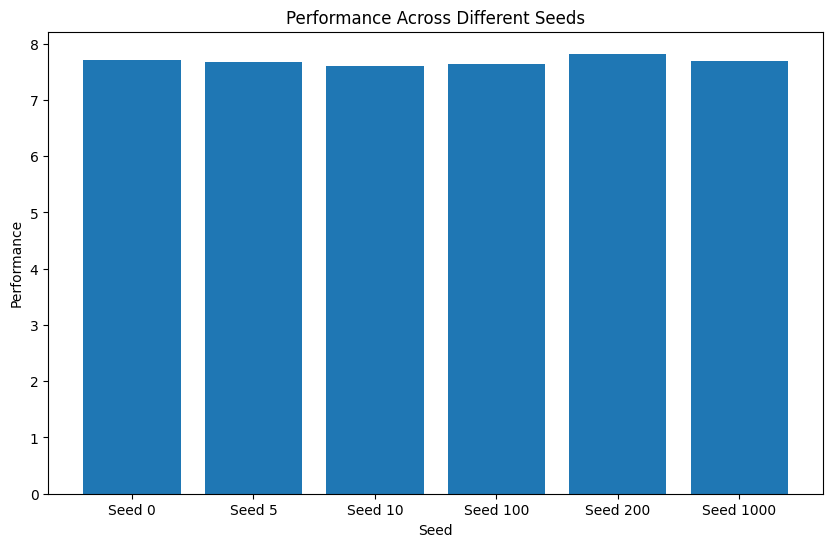

Average performance: 7.692328403960068


In [247]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
# Seeds for different splits
seeds = [0, 5, 10, 100, 200, 1000]
performances = []

for seed in seeds:
    # Splitting the dataset into training and testing sets
    train_set, test_set = train_test_split(unique_words, test_size=0.2, random_state=seed)
    
    # Evaluating the guesser's performance on this split
    performance = test_guesser(my_amazing_ai_guesser, test_set)
    performances.append(performance)


# Plotting overall performance across different seeds
plt.figure(figsize=(10, 6))
plt.bar(['Seed {}'.format(seed) for seed in seeds], performances)
plt.xlabel('Seed')
plt.ylabel('Performance')
plt.title('Performance Across Different Seeds')
plt.show()

# Printing average performance
print("Average performance:", np.mean(performances))

In [248]:
np.mean(performances)

7.692328403960068

### Question 7 (0.5 mark)

**Instructions:** Explain your approach and discuss your result below. Please keep your explanation to a short paragraph.

##### Your answer BEGINS HERE

- 2-gram 的命中率不足50%，所以要另外找到一个方法fall back


##### Your answer ENDS HERE